In [7]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import math

In [2]:
def parse_label(path):
    raw = open(path).read()
    classnames =[]
    for cls in raw.split('\n'):
        if cls == '':
            continue
        classnames.append(cls)
    return classnames

def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)  # 读取原始文件
    image_decoded = tf.io.decode_jpeg(image_string,channels=3)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [224, 224]) / 255.0
    return image_resized, label

def load_data(dirs):
    images_name = []
    labels = []
    for i,file_dir in enumerate(dirs):
        filename = tf.constant([file_dir + '/' + filename for filename in os.listdir(file_dir)])
        images_name = tf.concat([images_name,filename],axis=-1)
        labels = tf.concat([labels,tf.constant(i,shape=filename.shape[0])],axis=-1)
    print("total:%d" %  images_name.shape[0])
    train_dataset = tf.data.Dataset.from_tensor_slices((images_name, labels))
    train_dataset = train_dataset.map(
        map_func=_decode_and_resize,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return train_dataset

In [3]:
#设置超参数
num_epochs = 10
batch_size = 15
learning_rate_dense = 0.1
learning_rate_mobile = 0.001
buffer_size=10000

train_dir = './data/train/'
class_names = parse_label(train_dir+'classes_label.txt')
train_file_dirs = [train_dir+classname for classname in class_names] 
train_dataset = load_data(train_file_dirs)
train_dataset = train_dataset.shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

total:18126


In [4]:
#训练
model_d = tf.keras.applications.DenseNet121(weights=None,classes=len(class_names))
model_d.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_dense),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )

model_d.fit(train_dataset,epochs=num_epochs)
model_d.save('densenet-121-garbage.h5')

Epoch 1/5
1209/1209 [==============================] - 713s 486ms/step - loss: 2.8436 - sparse_categorical_accuracy: 0.2053
Epoch 2/5
1209/1209 [==============================] - 484s 396ms/step - loss: 2.1684 - sparse_categorical_accuracy: 0.3068
Epoch 3/5
1209/1209 [==============================] - 483s 396ms/step - loss: 2.1107 - sparse_categorical_accuracy: 0.3265
Epoch 4/5
1209/1209 [==============================] - 483s 396ms/step - loss: 2.0494 - sparse_categorical_accuracy: 0.3471
Epoch 5/5
1209/1209 [==============================] - 482s 395ms/step - loss: 1.9873 - sparse_categorical_accuracy: 0.3664


In [4]:
model_m = tf.keras.applications.MobileNetV2(weights=None,classes=len(class_names))
# model_m = tf.keras.models.load_model("mobilenet-garbage.h5")
model_m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_mobile),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )

model_m.fit(train_dataset,epochs=num_epochs)
model_m.save('mobilenet-garbage.h5')

Epoch 1/5
907/907 [==============================] - 347s 309ms/step - loss: 2.7486 - sparse_categorical_accuracy: 0.2029
Epoch 2/5
907/907 [==============================] - 251s 272ms/step - loss: 2.1372 - sparse_categorical_accuracy: 0.3262
Epoch 3/5
907/907 [==============================] - 252s 272ms/step - loss: 1.9587 - sparse_categorical_accuracy: 0.3847
Epoch 4/5
907/907 [==============================] - 253s 274ms/step - loss: 1.8510 - sparse_categorical_accuracy: 0.4179
Epoch 5/5
907/907 [==============================] - 252s 273ms/step - loss: 1.7911 - sparse_categorical_accuracy: 0.4385


In [4]:
model_m = tf.keras.models.load_model("mobilenet-garbage.h5")

pre:棉签 	true;报纸
pre:鞋 	true;鞋
pre:衣服 	true;鞋
pre:玻璃 	true;鞋
pre:口服液瓶 	true;易拉罐
pre:玻璃 	true;报纸


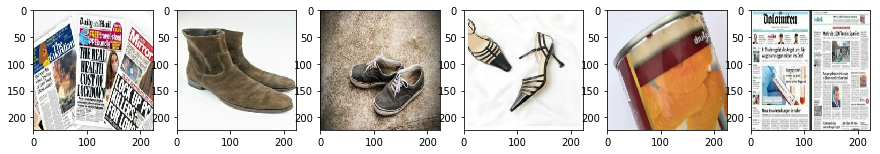

pre:口服液瓶 	true;口服液瓶
pre:口服液瓶 	true;口服液瓶
pre:玻璃 	true;玻璃
pre:衣服 	true;衣服
pre:电池 	true;口服液瓶
pre:纸箱 	true;衣服


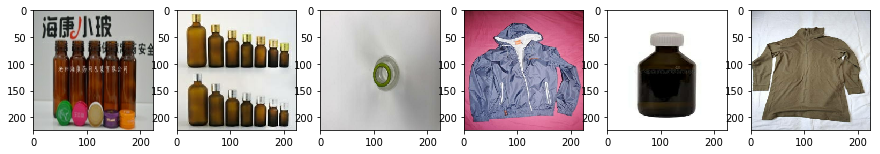

pre:口服液瓶 	true;口服液瓶
pre:衣服 	true;衣服
pre:电池 	true;鞋


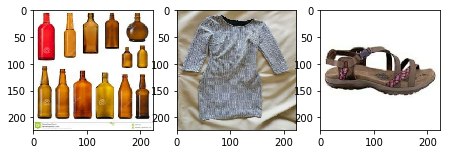

0.4666666666666667


In [9]:
# 查看预测效果

for images, labels in train_dataset: 
    width,height = 6,math.ceil(batch_size/6.0)
    acc=0
    output = model_d(images,training=True)
    for i in range(height):
        plt.figure(figsize=(15, 15))
        for j in range(width):
            plt.subplot(1,width,j+1)
#             print(output[i*width+j].numpy())
            index = tf.math.argmax(output[i*width+j]).numpy()
#             print(index)
            true = labels[i*width+j].numpy()
            if index == true:
                acc+=1
            print('pre:%s \ttrue;%s'%(class_names[index],class_names[true]))
#             plt.title(class_names[index]+' ('+class_names[true]+')')
            plt.imshow(images[i*width+j].numpy())
            if i*width+j == batch_size-1:
                    break
        plt.show()
    print(acc/batch_size)
    break